In [40]:
import os
import sys
import docopt
import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [43]:
from IPython.display import HTML, display
from ipywidgets import interact, interactive
# from plotting_functions import *
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LogisticRegression
# from utils import *

ModuleNotFoundError: No module named 'plotting_functions'

In [69]:
import pickle

In [16]:
df = pd.read_csv(
    "../../data/raw/abalone.data",
    names=[
        "Sex",
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
        "Rings",
    ],
    header=0,
)

# Add a classification target columns. If rings > 11, then classified as old
df["Is old"] = np.where(df["Rings"] > 11, "old", "young")
df.head()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
X_train = train_df.drop(columns=['Is old'])
X_test = test_df.drop(columns=['Is old'])
y_train = train_df['Is old']
y_test = test_df['Is old']

In [17]:
# create column transformer for analysis pipeline

categorical_feature = ['Sex']
numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 
'Shucked weight', 'Viscera weight', 'Shell weight']
target = 'Is old'
drop_feature = ['Rings']

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), 
     categorical_feature),
    ("drop", drop_feature),
)

In [114]:
# fit the model by using random search CV

lr = LogisticRegression(max_iter=2000)
pipe = make_pipeline(preprocessor, lr)
param_grid = {"logisticregression__C": 10.0 ** np.arange(-3, 6)}

random_search = RandomizedSearchCV(pipe,
                                   param_distributions = param_grid,
                                   n_jobs = -1,
                                   n_iter = 10,
                                   cv = 5,
                                   random_state = 123)
random_search.fit(pd.DataFrame(X_train), y_train)

C:\Users\Maoli\miniconda3\envs\571\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['Length',
                                                                                'Diameter',
                                                                                'Height',
                                                                                'Whole '
                                                                                'weight',
                                                                                'Shucked '
                                                                                'weight',
                                                                                'V

In [115]:
# view the training results in a data frame

train_results = pd.DataFrame(random_search.cv_results_)[
    [   "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()
train_results

,mean_test_score,param_logisticregression__C,mean_fit_time
rank_test_score,,,
1,0.826403,100.0,0.041321
1,0.826403,1000.0,0.037464
1,0.826403,10000.0,0.036820
1,0.826403,100000.0,0.030387
5,0.826104,10.0,0.045194
6,0.822811,1.0,0.040864
7,0.820115,0.1,0.033799
8,0.798865,0.01,0.028923
9,0.775518,0.001,0.026820


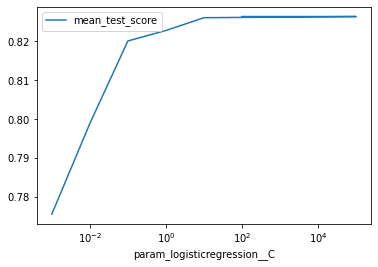

In [116]:
# train_results.plot(kind="line", y="mean_test_score")
from matplotlib import pyplot
train_results.plot(x = "param_logisticregression__C", y = "mean_test_score")

pyplot.xscale("log")
plt.savefig("../../models/cv_result.png")

In [30]:
# pick the final model and predict test data

best_c = train_results.iloc[1, 0]

pipe_best = make_pipeline(preprocessor, LogisticRegression(C = best_c, max_iter=2000))
pipe_best.fit(X_train, y_train)

pipe_best.score(X_test, y_test)

0.8421052631578947

In [70]:
random_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex']),
                                                 ('drop', 'drop', ['Rings'])])),
                ('logisticregression',
                 LogisticRegression(C=100.0, max_iter=

In [59]:
feature_names = np.array(pipe_best[:-1].get_feature_names_out())
coeffs = pipe_best.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)
coeff_df_sorted

,Coefficient
standardscaler__Shucked weight,4.142553
onehotencoder__Sex_I,0.983024
standardscaler__Viscera weight,0.818804
standardscaler__Length,0.537147
onehotencoder__Sex_F,0.129540
onehotencoder__Sex_M,0.121077
standardscaler__Height,-0.248307
standardscaler__Diameter,-0.538840
standardscaler__Shell weight,-1.070738
standardscaler__Whole weight,-4.306860


In [34]:
pipe_best.classes_

array(['old', 'young'], dtype=object)

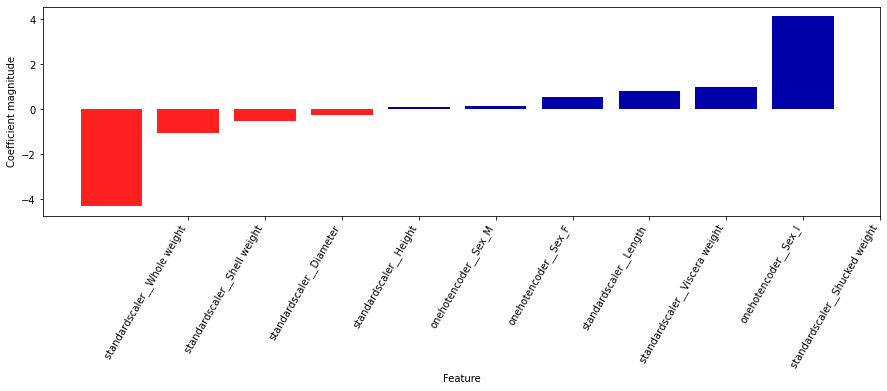

In [68]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=5)
plt.savefig("../../models/coeff.png")

In [ ]:
# export tables

import dataframe_image as dfi
dfi.export(train_results,"../../models/train_results.png")
dfi.export(coeff_df_sorted,"../../models/coeff_sorted.png")